In [14]:
import pandas as pd
import re
import torch
from torch_geometric.data import Data
from transformers import BertTokenizer, BertModel
import numpy as np
import ast
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from torch.utils.data import DataLoader
from sklearn.metrics.pairwise import cosine_similarity

# # Load the dataset
file_path = "updated_firefox_issues.csv"
# firefox_issues_df = balanced_df
firefox_issues_df = pd.read_csv(file_path)
firefox_issues_df =firefox_issues_df[:18000] 

# Clean and preprocess data
firefox_issues_df.dropna(subset=['severity', 'product', 'component', 'priority', 'status'], inplace=True)
firefox_issues_df['summary'] = firefox_issues_df['summary'].str.lower()
firefox_issues_df['summary'] = firefox_issues_df['summary'].apply(lambda x: re.sub(r'[^a-z0-9\s]', '', x))

firefox_issues_df.replace('--', pd.NA, inplace=True)
firefox_issues_df.dropna(subset=['severity', 'priority'], inplace=True)

# Encode 'Product', 'Component', and 'Status' using label encoding
product_encoder = LabelEncoder()
component_encoder = LabelEncoder()
status_encoder = LabelEncoder()
firefox_issues_df['product_encoded'] = product_encoder.fit_transform(firefox_issues_df['product'])
firefox_issues_df['component_encoded'] = component_encoder.fit_transform(firefox_issues_df['component'])
firefox_issues_df['status_encoded'] = status_encoder.fit_transform(firefox_issues_df['status'])

# Initialize BERT tokenizer and model with a specified cache directory
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', cache_dir='cache')
model = BertModel.from_pretrained('bert-base-uncased', cache_dir='cache')


# from transformers import RobertaTokenizer, RobertaModel

# # Initialize RoBERTa tokenizer and model
# tokenizer = RobertaTokenizer.from_pretrained('roberta-base' ,cache_dir='cache')
# model = RobertaModel.from_pretrained('roberta-base', cache_dir='cache')


# Set the device to GPU (if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


# Function for batch processing of summaries to obtain BERT embeddings
def batch_encode_summaries(summaries, tokenizer, model, batch_size=16):
    dataloader = DataLoader(summaries, batch_size=batch_size, shuffle=False)
    text_features_list = []

    for batch_summaries in dataloader:
        inputs = tokenizer(batch_summaries, padding=True, truncation=True, max_length=512, return_tensors="pt").to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        batch_text_features = outputs.last_hidden_state.mean(dim=1)
        text_features_list.append(batch_text_features.cpu())  # Move to CPU to avoid GPU memory overload

    return torch.cat(text_features_list, dim=0)


# Encode summaries in batches to get text features
text_features = batch_encode_summaries(firefox_issues_df['summary'].tolist(), tokenizer, model, batch_size=16)

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Select the columns for scaling
features_to_scale = firefox_issues_df[['product_encoded', 'component_encoded', 'status_encoded']]

# Fit the scaler to the features and transform them to a 0-1 range
scaled_features = scaler.fit_transform(features_to_scale)

# Update the dataframe with the scaled features
firefox_issues_df[['product_encoded', 'component_encoded', 'status_encoded']] = scaled_features

# Calculate 'count of blocks' and 'count of depends_on'
firefox_issues_df['blocks_count'] = firefox_issues_df['blocks'].apply(lambda x: len(ast.literal_eval(x)) if pd.notnull(x) else 0)
firefox_issues_df['depends_on_count'] = firefox_issues_df['depends_on'].apply(lambda x: len(ast.literal_eval(x)) if pd.notnull(x) else 0)

# Scale the counts
count_features = firefox_issues_df[['blocks_count', 'depends_on_count']]
scaled_count_features = scaler.fit_transform(count_features)
firefox_issues_df[['blocks_count', 'depends_on_count']] = scaled_count_features

# Prepare the features tensor including the new count features
features_tensor = torch.tensor(firefox_issues_df[['product_encoded', 'component_encoded', 'status_encoded', 'blocks_count', 'depends_on_count']].values, dtype=torch.float)

# Concatenate the BERT embeddings with the scaled features
features = torch.cat((text_features, features_tensor), dim=1)

# # Prepare edge index and map issue IDs to node indices
# node_id_mapping = {node_id: idx for idx, node_id in enumerate(firefox_issues_df['id'])}
# edge_index = []


# Compute cosine similarity
similarity_matrix = cosine_similarity(text_features.numpy())

# Define a similarity threshold
similarity_threshold = 0.95

# Prepare edge index
edge_index = []
node_id_mapping = {node_id: idx for idx, node_id in enumerate(firefox_issues_df['id'])}

for i in range(similarity_matrix.shape[0]):
    for j in range(i + 1, similarity_matrix.shape[1]):
        if similarity_matrix[i, j] >= similarity_threshold:
            edge_index.append([i, j])
            edge_index.append([j, i])  # Adding reverse edge for undirected graph

edge_index_tensor = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

# Convert the 'priority' and 'severity' columns to tensors
priority_labels = torch.tensor(firefox_issues_df['priority'].values, dtype=torch.long)
severity_labels = torch.tensor(firefox_issues_df['severity'].values, dtype=torch.long)

# Create PyTorch Geometric Data object
data = Data(x=features, edge_index=edge_index_tensor, y_priority=priority_labels, y_severity=severity_labels)

# Save the Data object
data_save_path = 'firefox_issues_data.pt'
torch.save(data, data_save_path)


In [2]:
# # Number of Nodes
# num_nodes = data.num_nodes
# print(f"Number of nodes: {num_nodes}")

# # Number of Edges
# num_edges = data.num_edges
# print(f"Number of edges: {num_edges}")

# # Average Node Degree
# avg_degree = num_edges / num_nodes
# print(f"Average node degree: {avg_degree:.2f}")

# # Number of Features per Node
# num_features = data.num_features
# print(f"Number of features per node: {num_features}")

# # Checking for Isolated Nodes
# num_isolated_nodes = sum(data.degree() == 0).item()
# print(f"Number of isolated nodes: {num_isolated_nodes}")

# # Checking for Self-loops
# num_self_loops = data.contains_self_loops().item()
# print(f"Number of self-loops: {num_self_loops}")

# # Graph Density
# density = num_edges / (num_nodes * (num_nodes - 1))
# print(f"Graph density: {density:.6f}")

# # Edge Index Range (Min and Max Node IDs)
# edge_index_min = data.edge_index.min().item()
# edge_index_max = data.edge_index.max().item()
# print(f"Edge index range: Node ID {edge_index_min} to Node ID {edge_index_max}")


In [15]:
# Assuming you have defined num_classes_priority and num_classes_severity
num_classes_priority = 4  # Example: 6 priority classes
num_classes_severity = 3  # Example: 6 severity classes

# Check the range for priority labels
priority_label_min = data.y_priority.min().item()
priority_label_max = data.y_priority.max().item()

if priority_label_min < 0 or priority_label_max >= num_classes_priority:
    print(f"Priority labels out of expected range [0, {num_classes_priority-1}]: Min = {priority_label_min}, Max = {priority_label_max}")
else:
    print(f"Priority labels within expected range [0, {num_classes_priority-1}].")

# Check the range for severity labels
severity_label_min = data.y_severity.min().item()
severity_label_max = data.y_severity.max().item()

if severity_label_min < 0 or severity_label_max >= num_classes_severity:
    print(f"Severity labels out of expected range [0, {num_classes_severity-1}]: Min = {severity_label_min}, Max = {severity_label_max}")
else:
    print(f"Severity labels within expected range [0, {num_classes_severity-1}].")


Priority labels out of expected range [0, 3]: Min = 1, Max = 4
Severity labels out of expected range [0, 2]: Min = 1, Max = 3


In [16]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv

class FirefoxIssueGraphSAGE(torch.nn.Module):
    def __init__(self, num_node_features, hidden_units):
        super(FirefoxIssueGraphSAGE, self).__init__()
        self.conv1 = SAGEConv(num_node_features, hidden_units)
        self.dropout = torch.nn.Dropout(0.5)  # Adjust dropout rate as needed
        self.out_priority = torch.nn.Linear(hidden_units, 7)
        self.out_severity = torch.nn.Linear(hidden_units, 6)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)  # Apply dropout
        priority = self.out_priority(x)
        severity = self.out_severity(x)
        return F.log_softmax(priority, dim=1), F.log_softmax(severity, dim=1)

model = FirefoxIssueGraphSAGE(num_node_features=features.shape[1], hidden_units=110)


In [17]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv, GATConv

class HybridGNN(torch.nn.Module):
    def __init__(self, num_node_features, num_classes_priority, num_classes_severity, num_units):
        super(HybridGNN, self).__init__()

        # First layer is a GraphSAGE layer
        self.conv1 = SAGEConv(num_node_features, num_units)

        # Second layer is a GAT layer with multi-head attention
        self.conv2 = GATConv(num_units, num_units // 2, heads=2, concat=True)

        # Final output features adjusted for concatenated multi-head attention
        final_out_features = num_units  # Assuming concat=True doubles the feature size

        # Define separate layers for 'priority' and 'severity' with adjusted class counts
        self.out_priority = torch.nn.Linear(final_out_features, 7)  # Adjusted for 'priority'
        self.out_severity = torch.nn.Linear(final_out_features, 6)  # Correct for 'severity'

    def forward(self, x, edge_index):
        # GraphSAGE convolution
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)  # Apply dropout after GraphSAGE

        # GAT convolution
        x = self.conv2(x, edge_index)
        x = F.elu(x)  # ELU activation for GAT
        x = F.dropout(x, training=self.training)  # Apply dropout after GAT

        # Output layers for 'priority' and 'severity'
        priority = self.out_priority(x)
        severity = self.out_severity(x)

        return F.log_softmax(priority, dim=1), F.log_softmax(severity, dim=1)

# Instantiate the model with the same number of units
# model = HybridGNN(num_node_features=770, num_classes_priority=7, num_classes_severity=6, num_units=110)
model = HybridGNN(num_node_features=773, num_classes_priority=4, num_classes_severity=3, num_units=128)



In [18]:
import torch
import numpy as np

# Assuming 'data' is your PyTorch Geometric Data object

# Calculate the total number of nodes
num_nodes = data.x.size(0)

# Define the split sizes
train_size = 0.70  # 70% of the data for training
val_size = 0.15  # 15% of the data for validation
test_size = 0.15  # 15% of the data for testing

# Generate shuffled indices
indices = torch.randperm(num_nodes)

# Calculate the number of nodes for each split
num_train_nodes = int(train_size * num_nodes)
num_val_nodes = int(val_size * num_nodes)

# Split the indices for each set
train_indices = indices[:num_train_nodes]
val_indices = indices[num_train_nodes:num_train_nodes + num_val_nodes]
test_indices = indices[num_train_nodes + num_val_nodes:]

# Create boolean masks
data.train_mask = torch.zeros(num_nodes, dtype=torch.bool)
data.val_mask = torch.zeros(num_nodes, dtype=torch.bool)
data.test_mask = torch.zeros(num_nodes, dtype=torch.bool)

data.train_mask[train_indices] = True
data.val_mask[val_indices] = True
data.test_mask[test_indices] = True

# Calculate the number of nodes in each set
num_nodes_train = data.train_mask.sum().item()
num_nodes_val = data.val_mask.sum().item()
num_nodes_test = data.test_mask.sum().item()

print(f"Number of nodes in the training set: {num_nodes_train}")
print(f"Number of nodes in the validation set: {num_nodes_val}")
print(f"Number of nodes in the test set: {num_nodes_test}")



Number of nodes in the training set: 12105
Number of nodes in the validation set: 2593
Number of nodes in the test set: 2595


Text(0, 0.5, 'Count')

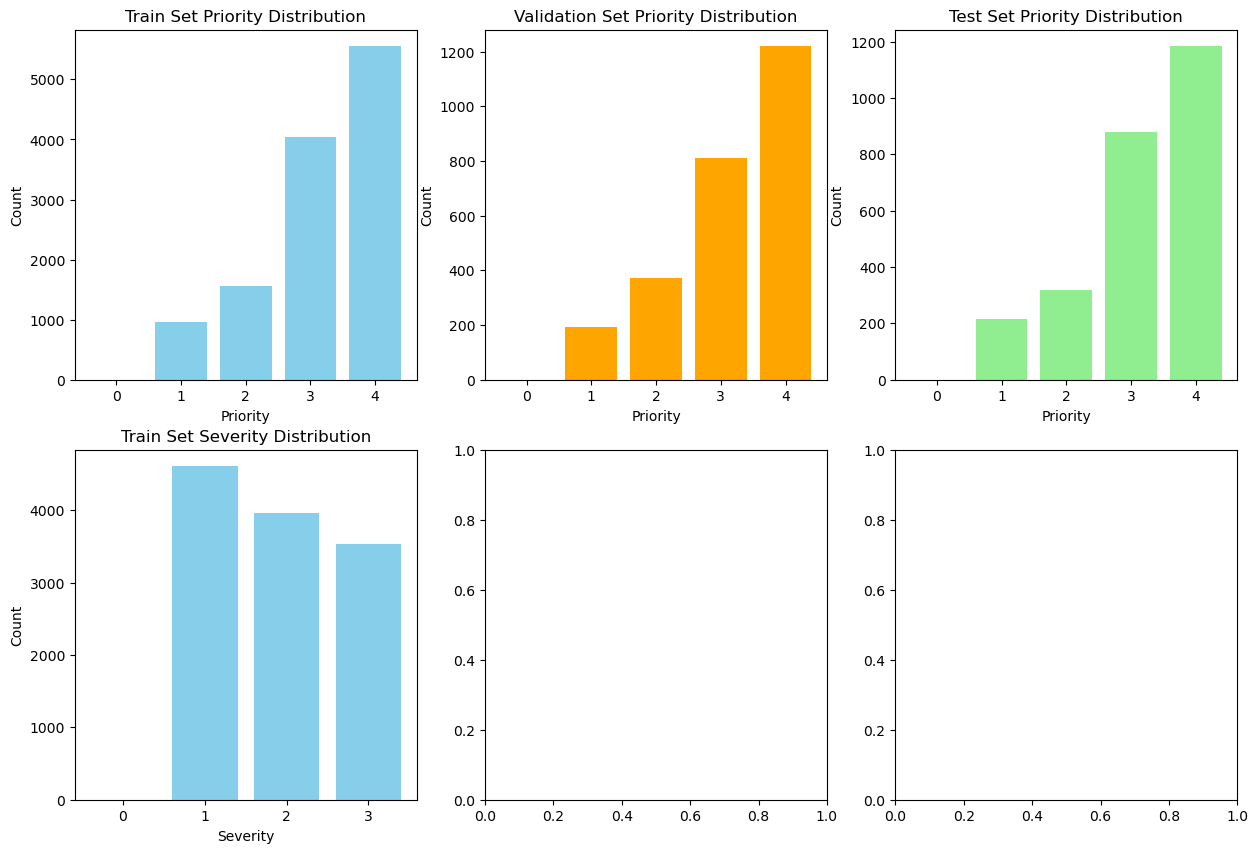

In [19]:
import matplotlib.pyplot as plt

# Assuming 'data' is your PyTorch Geometric Data object and the masks are already created as shown in your provided code snippet

# Apply masks to the 'priority' and 'severity' labels
train_priority = data.y_priority[data.train_mask]
val_priority = data.y_priority[data.val_mask]
test_priority = data.y_priority[data.test_mask]

train_severity = data.y_severity[data.train_mask]
val_severity = data.y_severity[data.val_mask]
test_severity = data.y_severity[data.test_mask]

# Calculate value counts for each set and label
train_priority_counts = torch.bincount(train_priority).numpy()
val_priority_counts = torch.bincount(val_priority).numpy()
test_priority_counts = torch.bincount(test_priority).numpy()

train_severity_counts = torch.bincount(train_severity).numpy()
val_severity_counts = torch.bincount(val_severity).numpy()
test_severity_counts = torch.bincount(test_severity).numpy()

# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Plot 'priority' distributions
axes[0, 0].bar(range(len(train_priority_counts)), train_priority_counts, color='skyblue')
axes[0, 0].set_title('Train Set Priority Distribution')
axes[0, 0].set_xlabel('Priority')
axes[0, 0].set_ylabel('Count')

axes[0, 1].bar(range(len(val_priority_counts)), val_priority_counts, color='orange')
axes[0, 1].set_title('Validation Set Priority Distribution')
axes[0, 1].set_xlabel('Priority')
axes[0, 1].set_ylabel('Count')

axes[0, 2].bar(range(len(test_priority_counts)), test_priority_counts, color='lightgreen')
axes[0, 2].set_title('Test Set Priority Distribution')
axes[0, 2].set_xlabel('Priority')
axes[0, 2].set_ylabel('Count')

# Plot 'severity' distributions
axes[1, 0].bar(range(len(train_severity_counts)), train_severity_counts, color='skyblue')
axes[1, 0].set_title('Train Set Severity Distribution')
axes[1, 0].set_xlabel('Severity')
axes[1, 0].set_ylabel('Count')

# axes[1, 1].bar(range(len(val_severity_counts)), val_severity_counts, color='orange')
# axes[1, 1].set_title('Validation Set Severity Distribution


In [8]:
criterion_priority = torch.nn.CrossEntropyLoss()
criterion_severity = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # You can adjust the learning rate as needed
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)


In [21]:
num_epochs = 300  # Define the number of epochs
log_interval = 10  # Interval at which to log training status


for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    priority_logits, severity_logits = model(data.x, data.edge_index)

    # Apply the mask to the entire node-wise prediction tensor
    masked_priority_logits = priority_logits[data.train_mask]
    masked_severity_logits = severity_logits[data.train_mask]

    # Get the corresponding labels for the masked nodes
    masked_y_priority = data.y_priority[data.train_mask.nonzero(as_tuple=True)[0]]
    masked_y_severity = data.y_severity[data.train_mask.nonzero(as_tuple=True)[0]]

    # Compute loss for each task
    loss_priority = criterion_priority(masked_priority_logits, masked_y_priority)
    loss_severity = criterion_severity(masked_severity_logits, masked_y_severity)

    # Combine losses and perform backpropagation
    loss = loss_priority + loss_severity  # You might want to weight these losses differently
    loss.backward()
    optimizer.step()

    # Log training information
    if epoch % log_interval == 0:
        print(f'Epoch: {epoch}/{num_epochs}, Total Loss: {loss.item():.4f}, '
              f'Priority Loss: {loss_priority.item():.4f}, Severity Loss: {loss_severity.item():.4f}')


Epoch: 0/300, Total Loss: 3.6600, Priority Loss: 1.8815, Severity Loss: 1.7785
Epoch: 10/300, Total Loss: 3.6567, Priority Loss: 1.8793, Severity Loss: 1.7774
Epoch: 20/300, Total Loss: 3.6555, Priority Loss: 1.8782, Severity Loss: 1.7773
Epoch: 30/300, Total Loss: 3.6582, Priority Loss: 1.8810, Severity Loss: 1.7772
Epoch: 40/300, Total Loss: 3.6594, Priority Loss: 1.8813, Severity Loss: 1.7781
Epoch: 50/300, Total Loss: 3.6593, Priority Loss: 1.8804, Severity Loss: 1.7789
Epoch: 60/300, Total Loss: 3.6600, Priority Loss: 1.8828, Severity Loss: 1.7772
Epoch: 70/300, Total Loss: 3.6591, Priority Loss: 1.8813, Severity Loss: 1.7777
Epoch: 80/300, Total Loss: 3.6595, Priority Loss: 1.8814, Severity Loss: 1.7781
Epoch: 90/300, Total Loss: 3.6586, Priority Loss: 1.8810, Severity Loss: 1.7776
Epoch: 100/300, Total Loss: 3.6577, Priority Loss: 1.8805, Severity Loss: 1.7772
Epoch: 110/300, Total Loss: 3.6587, Priority Loss: 1.8806, Severity Loss: 1.7781
Epoch: 120/300, Total Loss: 3.6569, Pri

In [10]:
model.eval()
with torch.no_grad():
    # Forward pass using the entire graph
    priority_logits, severity_logits = model(data.x, data.edge_index)

    # Apply the test mask to logits and labels for loss calculation
    test_priority_logits = priority_logits[data.val_mask]
    test_severity_logits = severity_logits[data.val_mask]

    # Get the corresponding labels for the test mask
    test_y_priority = data.y_priority[data.val_mask.nonzero(as_tuple=True)[0]]
    test_y_severity = data.y_severity[data.val_mask.nonzero(as_tuple=True)[0]]

    # Compute loss for each task
    test_loss_priority = criterion_priority(test_priority_logits, test_y_priority)
    test_loss_severity = criterion_severity(test_severity_logits, test_y_severity)
    test_loss = test_loss_priority + test_loss_severity

    print("prop loss", test_loss_priority.item())
    print("test_loss_severity loss", test_loss_severity.item())
    print(f'Test Loss: {test_loss.item()}')


prop loss 0.7019981741905212
test_loss_severity loss 0.835710883140564
Test Loss: 1.5377089977264404


In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

model.eval()
with torch.no_grad():
    # Forward pass using the entire graph
    priority_logits, severity_logits = model(data.x, data.edge_index)

    # Apply the test mask to logits and labels for evaluation
    test_priority_logits = priority_logits[data.test_mask]
    test_severity_logits = severity_logits[data.test_mask]

    # Get the corresponding labels for the test mask
    test_y_priority = data.y_priority[data.test_mask.nonzero(as_tuple=True)[0]]
    test_y_severity = data.y_severity[data.test_mask.nonzero(as_tuple=True)[0]]

    # Convert logits to predicted classes
    _, predicted_priorities = torch.max(test_priority_logits, 1)
    _, predicted_severities = torch.max(test_severity_logits, 1)

    # Convert tensors to NumPy arrays for use with sklearn metrics
    true_priorities = test_y_priority.cpu().numpy()
    true_severities = test_y_severity.cpu().numpy()
    predicted_priorities = predicted_priorities.cpu().numpy()
    predicted_severities = predicted_severities.cpu().numpy()

    # # Add print statements for actual and predicted labels
    # print("Actual Priorities:", true_priorities)
    # print("Predicted Priorities:", predicted_priorities)
    # print("Actual Severities:", true_severities)
    # print("Predicted Severities:", predicted_severities)

    # Calculate metrics for 'priority'
    accuracy_priority = accuracy_score(true_priorities, predicted_priorities)
    precision_priority = precision_score(true_priorities, predicted_priorities, average='weighted')
    recall_priority = recall_score(true_priorities, predicted_priorities, average='weighted')
    f1_priority = f1_score(true_priorities, predicted_priorities, average='weighted')

    # Calculate metrics for 'severity'
    accuracy_severity = accuracy_score(true_severities, predicted_severities)
    precision_severity = precision_score(true_severities, predicted_severities, average='weighted')
    recall_severity = recall_score(true_severities, predicted_severities, average='weighted')
    f1_severity = f1_score(true_severities, predicted_severities, average='weighted')

    # Print the metrics
    print(f"Priority - Accuracy: {accuracy_priority:.4f}, Precision: {precision_priority:.4f}, "
          f"Recall: {recall_priority:.4f}, F1: {f1_priority:.4f}")
    print(f"Severity - Accuracy: {accuracy_severity:.4f}, Precision: {precision_severity:.4f}, "
          f"Recall: {recall_severity:.4f}, F1: {f1_severity:.4f}")
# Generate detailed classification report for 'priority'
    report_priority = classification_report(true_priorities, predicted_priorities, target_names=['1','2','3','4'], output_dict=False)
    print("Classification Report for Priority:\n", report_priority)
    
    # Generate detailed classification report for 'severity'
    report_severity = classification_report(true_severities, predicted_severities, target_names=['1','2','3'], output_dict=False)
    print("Classification Report for Severity:\n", report_severity)



Priority - Accuracy: 0.7315, Precision: 0.7093, Recall: 0.7315, F1: 0.7104
Severity - Accuracy: 0.6449, Precision: 0.6250, Recall: 0.6449, F1: 0.6034
Classification Report for Priority:
               precision    recall  f1-score   support

           1       0.41      0.21      0.28       195
           2       0.36      0.21      0.27       298
           3       0.61      0.81      0.69       653
           4       0.93      0.93      0.93      1014

    accuracy                           0.73      2160
   macro avg       0.58      0.54      0.54      2160
weighted avg       0.71      0.73      0.71      2160

Classification Report for Severity:
               precision    recall  f1-score   support

           1       0.67      0.73      0.70       998
           2       0.63      0.84      0.72       744
           3       0.51      0.11      0.17       418

    accuracy                           0.64      2160
   macro avg       0.60      0.56      0.53      2160
weighted avg   

In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

model.eval()
with torch.no_grad():
    # Forward pass using the entire graph
    priority_logits, severity_logits = model(data.x, data.edge_index)

    # Apply the test mask to logits and labels for evaluation
    test_priority_logits = priority_logits[data.test_mask]
    test_severity_logits = severity_logits[data.test_mask]

    # Get the corresponding labels for the test mask
    test_y_priority = data.y_priority[data.test_mask.nonzero(as_tuple=True)[0]]
    test_y_severity = data.y_severity[data.test_mask.nonzero(as_tuple=True)[0]]

    # Convert logits to predicted classes
    _, predicted_priorities = torch.max(test_priority_logits, 1)
    _, predicted_severities = torch.max(test_severity_logits, 1)

    # Convert tensors to NumPy arrays for use with sklearn metrics
    true_priorities = test_y_priority.cpu().numpy()
    true_severities = test_y_severity.cpu().numpy()
    predicted_priorities = predicted_priorities.cpu().numpy()
    predicted_severities = predicted_severities.cpu().numpy()

    # # Add print statements for actual and predicted labels
    # print("Actual Priorities:", true_priorities)
    # print("Predicted Priorities:", predicted_priorities)
    # print("Actual Severities:", true_severities)
    # print("Predicted Severities:", predicted_severities)

    # Calculate metrics for 'priority'
    accuracy_priority = accuracy_score(true_priorities, predicted_priorities)
    precision_priority = precision_score(true_priorities, predicted_priorities, average='weighted')
    recall_priority = recall_score(true_priorities, predicted_priorities, average='weighted')
    f1_priority = f1_score(true_priorities, predicted_priorities, average='weighted')

    # Calculate metrics for 'severity'
    accuracy_severity = accuracy_score(true_severities, predicted_severities)
    precision_severity = precision_score(true_severities, predicted_severities, average='weighted')
    recall_severity = recall_score(true_severities, predicted_severities, average='weighted')
    f1_severity = f1_score(true_severities, predicted_severities, average='weighted')

    # Print the metrics
    print(f"Priority - Accuracy: {accuracy_priority:.4f}, Precision: {precision_priority:.4f}, "
          f"Recall: {recall_priority:.4f}, F1: {f1_priority:.4f}")
    print(f"Severity - Accuracy: {accuracy_severity:.4f}, Precision: {precision_severity:.4f}, "
          f"Recall: {recall_severity:.4f}, F1: {f1_severity:.4f}")
# Generate detailed classification report for 'priority'
    report_priority = classification_report(true_priorities, predicted_priorities, target_names=['1','2','3','4'], output_dict=False)
    print("Classification Report for Priority:\n", report_priority)
    
    # Generate detailed classification report for 'severity'
    report_severity = classification_report(true_severities, predicted_severities, target_names=['1','2','3'], output_dict=False)
    print("Classification Report for Severity:\n", report_severity)



Priority - Accuracy: 0.7315, Precision: 0.7093, Recall: 0.7315, F1: 0.7104
Severity - Accuracy: 0.6449, Precision: 0.6250, Recall: 0.6449, F1: 0.6034
Classification Report for Priority:
               precision    recall  f1-score   support

           1       0.41      0.21      0.28       195
           2       0.36      0.21      0.27       298
           3       0.61      0.81      0.69       653
           4       0.93      0.93      0.93      1014

    accuracy                           0.73      2160
   macro avg       0.58      0.54      0.54      2160
weighted avg       0.71      0.73      0.71      2160

Classification Report for Severity:
               precision    recall  f1-score   support

           1       0.67      0.73      0.70       998
           2       0.63      0.84      0.72       744
           3       0.51      0.11      0.17       418

    accuracy                           0.64      2160
   macro avg       0.60      0.56      0.53      2160
weighted avg   

In [13]:
# Save the trained model
torch.save(model.state_dict(), 'firefox_issues_model.pth')

# Save the encoders and scalers
import joblib
joblib.dump(product_encoder, 'product_encoder.pkl')
joblib.dump(component_encoder, 'component_encoder.pkl')
joblib.dump(status_encoder, 'status_encoder.pkl')
joblib.dump(scaler, 'scaler.pkl')


['scaler.pkl']